# MS Calculations

Notebook to crunch numbers for the MS.

by Cascade Tuholske 2020.02.23

In [5]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [6]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [7]:
#### Load Data

# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"
FN_IN = 'processed/All_data_HI406_figdata.csv'
#FN_IN = '/home/cascade/projects/UrbanHeat/data/processed/oldworkflow/All_data_Raw406_es_final_pdayadd.csv'

HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# Check it
HI_STATS.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,22,1983,2,52064.452435,52064.452435,73006.671133,1.041289e+05,1.041289e+05,0.0
1,1,26,1983,1,194088.886834,194088.886834,268055.635628,1.940889e+05,1.940889e+05,0.0
2,2,27,1983,1,80540.779940,80540.779940,93335.494324,8.054078e+04,8.054078e+04,0.0
3,3,28,1983,9,59320.971209,59320.971209,91449.606255,5.338887e+05,5.338887e+05,0.0
4,4,29,1983,8,336518.836621,336518.836621,533318.453653,2.692151e+06,2.692151e+06,0.0


In [ ]:
#### Drop 40 cities where P1983 == 40 -- see comments in Fig 2 & 3 code CPT 2020.03.03
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city IDS
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

# Global Trends

In [8]:
#### Total Change in people Days
data = HI_STATS.groupby('year')['people_days'].sum()
year = str(data.index[33])
value = str(data.values[33]/10**9)
print('person days in 2016 was '+value+' billion')

year = str(data.index[0])
value = str(data.values[0]/10**9)
print('person days in 1983 was '+value+' billion')

#### Pct Change in Poeple Days 1983 - 2016
pdays16 = data.iloc[len(data) -1]
pdays83 = data.iloc[0]
out = (data.iloc[len(data) -1] - data.iloc[0]) / data.iloc[0] * 100
print('pct increase in people days 83 - 16 is ', out)

person days in 2016 was 302.1115741966647 billion
person days in 1983 was 129.17285743460027 billion
pct increase in people days 83 - 16 is  133.88162203473954


In [9]:
#### Pct Pday Annual Increase from Heat
coef_pdays, r2_pdays, p_pdays = lm_func(HI_STATS, 'people_days') # regress pdays
coef_heat, r2_heat, p_heat = lm_func(HI_STATS, 'people_days_heat') # regreas heat

print('warming is what pct of total?', coef_heat/coef_pdays *100)

warming is what pct of total? 22.8857059206051


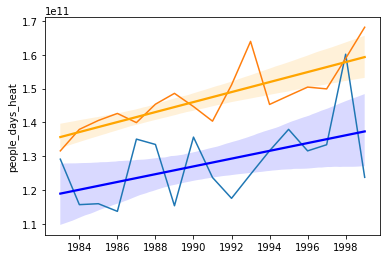

In [10]:
#### Share of exposure due to heat by decade

## 1983 - 1999
data1 = HI_STATS[(HI_STATS['year'] >= 1983) & (HI_STATS['year'] < 2000)]
coef1pop , r21pop, p1pop  = lm_func(data1 , 'people_days_pop')
coef1heat , r21heat, p1heat = lm_func(data1 , 'people_days_heat')

years = list(np.unique(data1['year']))
plt.plot(years, data1.groupby('year')['people_days_heat'].sum())
sns.regplot(years, data1.groupby('year')['people_days_heat'].sum(), 
            color = 'blue', scatter = False, truncate = True)

## 2000 - 2016
data2 = HI_STATS[(HI_STATS['year'] >= 2000) & (HI_STATS['year'] <= 2016)]
coef2heat , r22heat, p2heat = lm_func(data2 , 'people_days_heat')
coef2pop , r22pop, p1pop  = lm_func(data2 , 'people_days_pop')

years = list(np.unique(data1['year']))
plt.plot(years, data2.groupby('year')['people_days_heat'].sum())
sns.regplot(years, data2.groupby('year')['people_days_heat'].sum(), 
            color = 'orange', scatter = False, truncate = True)

In [11]:
## 2000 - 2016
data2pop = HI_STATS[(HI_STATS['year'] >= 1983) & (HI_STATS['year'] < 2000)]
coef2pop , r22pop, p1pop  = lm_func(data2pop , 'people_days_pop')

data2heat = HI_STATS[(HI_STATS['year'] >= 2000) & (HI_STATS['year'] <= 2016)]
coef2heat , r22heat, p2heat = lm_func(data2heat , 'people_days_heat')


In [12]:

## Estimates
print('From 83 - 99, contribution from heat was', coef1heat/(coef1pop+coef1heat))
print('From 00 - 16, contribution from heat was', coef2heat/(coef2pop+coef2heat))
print('From 83 - 00, heat was', coef1heat/10**9, round(p1heat, 3))
print('From 00 - 16, heat was', coef2heat/10**9)
print('From 83 - 00, pop was', coef1pop/10**9)
print('From 00 - 16, pop was', coef2pop/10**9)

From 83 - 99, contribution from heat was 0.24401113159812696
From 00 - 16, contribution from heat was 0.29330831852945566
From 83 - 00, heat was 1.146678199 0.051
From 00 - 16, heat was 1.474489616
From 83 - 00, pop was 3.552608229
From 00 - 16, pop was 3.552608229


# City-level

In [21]:
all_coefs = pd.read_csv(DATA_IN+'/processed/All_data_HI406_pdaysp05.csv')

In [46]:
all_coefs.columns

Index(['Unnamed: 0', 'ID_HDC_G0', 'coef_pdays', 'p_value_pdays',
       'ci_left_pdays', 'ci_right_pdays', 'coef_heat', 'p_value_heat',
       'ci_left_heat', 'ci_right_heat', 'coef_pop', 'p_value_pop',
       'ci_left_pop', 'ci_right_pop', 'coef_totDays', 'p_value_totDays',
       'ci_left_totDays', 'ci_right_totDays', 'coef_attrib',
       'coef_attrib_left', 'coef_attrib_right', 'coef_attrib_norm',
       'coef_attrib_norm_left', 'coef_attrib_norm_right', 'region',
       'intermediate-region', 'sub-region', 'CTR_MN_NM', 'GCPNT_LAT',
       'GCPNT_LON', 'P1983', 'P2016'],
      dtype='object')

In [33]:
#### Top Fifty Cities Worldwide Pdays
data = all_coefs[['ID_HDC_G0', 'CTR_MN_NM', 'coef_pdays']].sort_values('coef_pdays', ascending = False)
rank = list(range(1,len(data)+1))
data['rank'] = rank
data.head(50)

,ID_HDC_G0,CTR_MN_NM,coef_pdays,rank
6598,9872,Bangladesh,0.110810,1
7072,10715,Thailand,0.096119,2
7825,12080,China,0.082611,3
8290,12829,Philippines,0.078003,4
7646,11800,Vietnam,0.077375,5
3984,6955,India,0.076478,6
7685,11862,Indonesia,0.070063,7
1239,2125,Nigeria,0.050360,8
6420,9691,India,0.050287,9
3322,6169,Pakistan,0.050147,10


In [39]:
#### Delhi
city = 6955
data = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
coef, r2, p = lm_func(data, 'people_days')
print('Delhi increased', coef)

Delhi increased 76477979


In [40]:
#### Lagos
city = 2125
data = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
coef, r2, p = lm_func(data, 'people_days')
print('Lagos increased', coef)

Lagos increased 50359924


In [41]:
#### Miami 
city = 556
data = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
coef, r2, p = lm_func(data, 'people_days')
print('Miami increased', coef)

Miami increased 11112688


In [48]:
#### Top Fifty Cities Worldwide Heating
data = all_coefs[['ID_HDC_G0', 'CTR_MN_NM', 'coef_totDays']].sort_values('coef_totDays', ascending = False)
rank = list(range(1,len(data)+1))
data['rank'] = rank
data.head(50)

,ID_HDC_G0,CTR_MN_NM,coef_totDays,rank
751,1312,Brazil,4.465852,1
672,1223,Brazil,4.315661,2
7037,10633,Indonesia,4.115661,3
557,1068,Brazil,3.869519,4
3086,5713,Ethiopia,3.788235,5
544,1047,Brazil,3.745760,6
3055,5661,Ethiopia,3.553094,7
1371,2333,Nigeria,3.528953,8
3056,5662,Ethiopia,3.516272,9
523,1006,Brazil,3.506494,10
